# Forecasting Switzerland's Inflation Rate

Author: Ahmed Altakrouri
Date: October 2023

Data Source: https://www.worldbank.org/en/research/brief/inflation-database


### Notebook Content:

1. Reading and Preprocessing Data. 
2. Explanatory Data Analysis.
3. Statistical Analysis.
4. ARIMA Model
5. SARIMA Model.
6. Backtesting.


In [143]:

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
import matplotlib.dates as mdates

from pmdarima import auto_arima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


## Helper Functions:

In [144]:

def melt_dataframe_consumer_price_index(inflation_data, country, list_dates):
    inflation_data = inflation_data[inflation_data["Country"] == country]

    df_melted = pd.melt(
        inflation_data,
        id_vars=['Country Code',
                 'IMF Country Code',
                 'Country',
                 'Indicator Type',
                 'Series Name'],
        value_vars=[year for year in list_dates],
        var_name='year',
        value_name='value'
    )
    df_melted.drop(columns=["Country Code", "IMF Country Code", "Country", "Indicator Type", "Series Name"], axis=1,
                   inplace=True)
    return df_melted


def melt_dataframe_inflation_rate(inflation_data, country):
    inflation_data = inflation_data[inflation_data["Country"] == country]

    df_melted = pd.melt(
        inflation_data,
        id_vars=['Country Code',
                 'IMF Country Code',
                 'Country',
                 'Indicator Type',
                 'Series Name'],
        value_vars=[year for year in range(1970, 2023)],
        var_name='year',
        value_name='value'
    )

    df_melted.drop(columns=["Country Code", "IMF Country Code", "Country", "Indicator Type", "Series Name"], axis=1,
                   inplace=True)
    return df_melted


def get_country_data(inflation_data, country, list_dates):
    country_sample = melt_dataframe_consumer_price_index(inflation_data, country, list_dates)
    country_sample.rename(columns={"year": "YearMonth", "value": "HCPI"}, inplace=True)
    country_sample['YearMonth'] = country_sample['YearMonth'].astype(str)
    country_sample['YearMonth'] = country_sample['YearMonth'].str[:4] + '-' + country_sample['YearMonth'].str[4:]

    return country_sample


def get_country_data_annualy(inflation_data, country, list_dates):
    country_sample = melt_dataframe_consumer_price_index(inflation_data, country, list_dates)
    return country_sample


def get_monthly_inflation_from_CPI(country_sample):
    country_sample['Monthly Inflation Rate'] = ((country_sample['HCPI'] - country_sample['HCPI'].shift(1)) /
                                                country_sample['HCPI'].shift(1)) * 100

    return country_sample


def get_yearly_inflation_from_monthly(country_sample):
    df_new_format = pd.DataFrame(country_sample)

    df_new_format['YearMonth'] = pd.to_datetime(df_new_format['YearMonth'])

    yearly_avg_cpi_datetime = df_new_format.groupby(df_new_format['YearMonth'].dt.year).mean()['HCPI']

    # Calculate the yearly inflation rate using the yearly average CPI
    yearly_avg_inflation_rate_datetime = ((yearly_avg_cpi_datetime - yearly_avg_cpi_datetime.shift(
        1)) / yearly_avg_cpi_datetime.shift(1)) * 100

    yearly_avg_inflation_datetime = yearly_avg_inflation_rate_datetime.reset_index()
    yearly_avg_inflation_datetime.columns = ['Year', 'Yearly Inflation Rate (Avg)']

    return yearly_avg_inflation_datetime


def adf_test(series):
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))

    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')
    return


def series_transformation(series):
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_title('Transformed Series')
    ax1.plot(series)
    ax1.plot(series.rolling(window=12).mean(), color='crimson')
    ax1.plot(series.rolling(window=12).std(), color='black')

    ax2 = fig.add_subplot(1, 3, 2)
    plot_acf(series.dropna(), ax=ax2, lags=50, title='Autocorrelation')
    # plot 95% confidence intervals
    plt.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    plt.xlabel('lags')

    ax3 = fig.add_subplot(1, 3, 3)
    plot_pacf(series.dropna(), ax=ax3, lags=50, title='Partial Autocorrelation')
    plt.axhline(y=-1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    plt.axhline(y=1.96 / np.sqrt(len(series)), linestyle='--', color='gray')
    plt.xlabel('lags')
    plt.show()

    # ADF test
    result = adfuller(series.dropna(), regression='c', autolag='AIC')
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('P-value = {:.6f}, the series is likely stationary.'.format(result[1]))
    else:
        print('P-value = {:.6f}, the series is likely non-stationary.'.format(result[1]))
    return


def find_best_arima_params(series, max_p=5, max_d=5, max_q=5, verbose=True):
    warnings.filterwarnings("ignore")  # Ignore warning messages for clarity

    best_aic = float('inf')
    best_params = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                except Exception as e:
                    if verbose:
                        print(f"ARIMA({p},{d},{q}) - AIC: N/A - Error: {str(e)}")
                    continue

    if verbose:
        print(f"Best ARIMA{best_params} model - AIC: {best_aic}")

    return best_params


def find_best_arima_params_metric(series, max_p=5, max_d=5, max_q=5, verbose=True):
    warnings.filterwarnings("ignore")  # Ignore warning messages for clarity

    best_mse = float('inf')
    best_params = None

    for p in range(max_p + 1):
        for d in range(max_d + 1):
            for q in range(max_q + 1):
                try:
                    model = ARIMA(series, order=(p, d, q))
                    results = model.fit()
                    predicted = results.predict()
                    mse = ((series[d:] - predicted) ** 2).mean()  # Calculating MSE for in-sample predictions
                    if mse < best_mse:
                        best_mse = mse
                        best_params = (p, d, q)
                except Exception as e:
                    if verbose:
                        print(f"ARIMA({p},{d},{q}) - MSE: N/A - Error: {str(e)}")
                    continue

    if verbose:
        print(f"Best ARIMA{best_params} model - MSE: {best_mse}")

    return best_params


def visualize_cpi(data):
    plt.figure(figsize=(20, 6))
    sns.lineplot(x='YearMonth', y='HCPI', data=data)
    plt.title('Headline Consumer Price Index over Time', fontsize=20)
    plt.xlabel('YearMonth', fontsize=15)
    plt.ylabel('Headline CPI', fontsize=15)

    num_ticks = 40
    ticks = data['YearMonth'].unique()
    plt.xticks(ticks[::len(ticks) // num_ticks], rotation=45, fontsize=13)
    plt.yticks(fontsize=13)

    plt.tight_layout()
    plt.show()


def format_year(year_float):
    if year_float.is_integer():
        return str(int(year_float))
    else:
        return str(year_float)


def custom_round(val):
    if val == int(val):
        return int(val)
    else:
        return round(val, 1)



## Reading and Pre-processing Data:


In [145]:

data_path = "data/Inflation-data.xlsx"
inflation_excel_file = pd.ExcelFile(data_path)
inflation_excel_file.sheet_names


['Intro',
 'top',
 'hcpi_m',
 'hcpi_q',
 'hcpi_a',
 'ecpi_m',
 'ecpi_q',
 'ecpi_a',
 'fcpi_m',
 'fcpi_q',
 'fcpi_a',
 'ccpi_m',
 'ccpi_q',
 'ccpi_a',
 'ppi_m',
 'ppi_q',
 'ppi_a',
 'def_q',
 'def_a',
 'ccpi_m_e',
 'ccpi_q_e',
 'ccpi_a_e',
 'hcpi_q_t',
 'hcpi_q_c',
 'Aggregate']

In [146]:

overall_inflation = pd.read_excel(data_path,sheet_name="top")
overall_inflation.describe()


,Unnamed: 0,Unnamed: 1,Unnamed: 2
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


In [147]:

inflation_data = pd.read_excel(data_path,sheet_name="hcpi_m")
inflation_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Columns: 648 entries, Country Code to Note
dtypes: float64(636), object(12)
memory usage: 951.9+ KB


In [148]:

data_columns = inflation_data.columns.tolist()

to_remove = ['Country Code',
             'IMF Country Code',
             'Country',
             'Indicator Type',
             'Series Name',
             'Unnamed: 644',
             'Data source',
             'Base date',
             'Note']

list_dates = [item for item in data_columns if item not in to_remove]


In [149]:

Switzerland_sample = get_country_data(inflation_data,"Switzerland",list_dates)
Switzerland_sample.head(20)


,YearMonth,HCPI
0,1970-01,33.4
1,1970-02,33.4
2,1970-03,33.4
3,1970-04,33.4
4,1970-05,33.7
5,1970-06,33.9
6,1970-07,34.0
7,1970-08,34.1
8,1970-09,34.3
9,1970-10,34.5


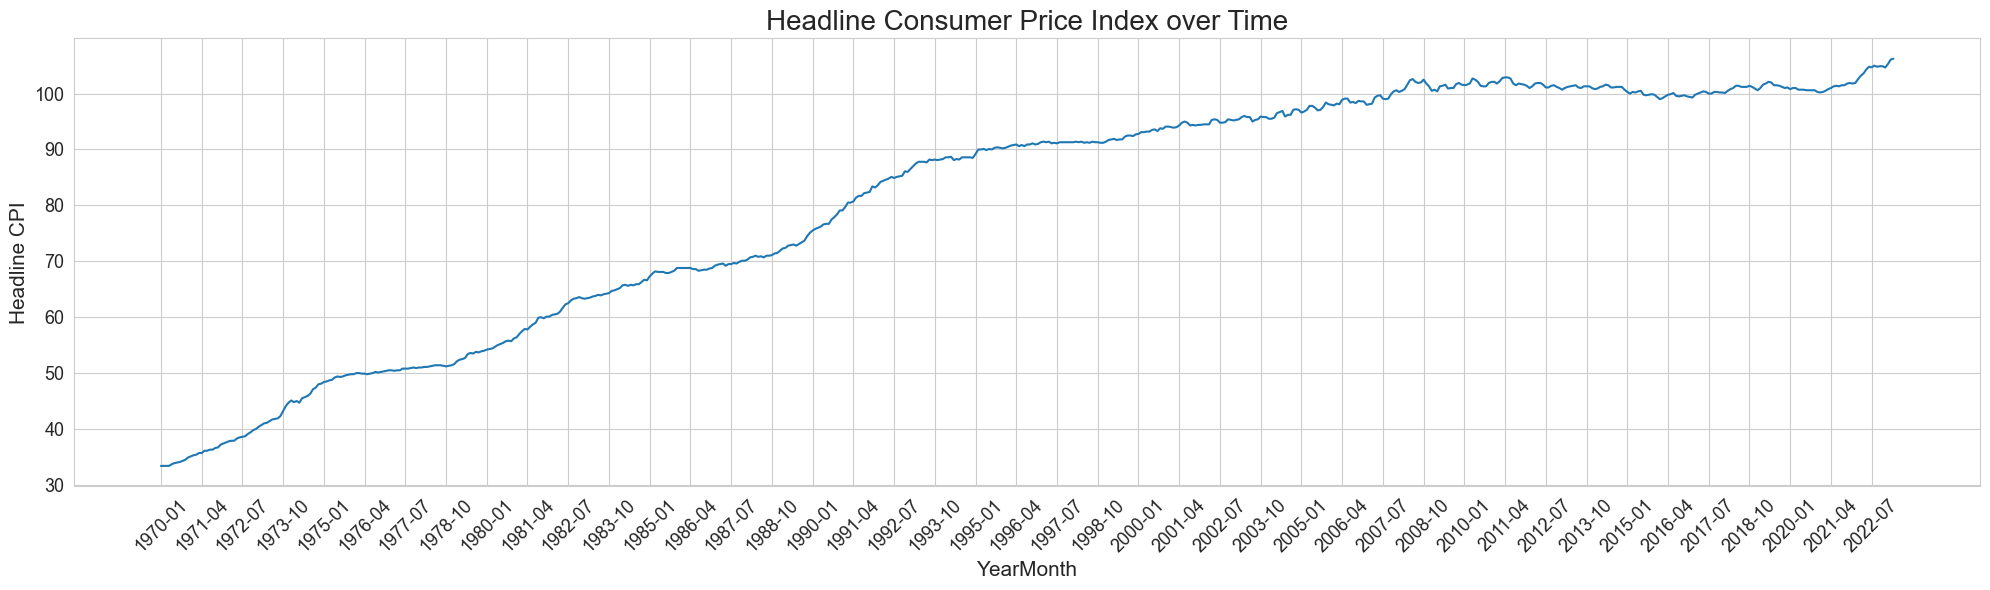

In [150]:

visualize_cpi(Switzerland_sample)


In [151]:

Switzerland_sample = get_monthly_inflation_from_CPI(Switzerland_sample)
Switzerland_sample.head(20)


,YearMonth,HCPI,Monthly Inflation Rate
0,1970-01,33.4,NaN
1,1970-02,33.4,0.0
2,1970-03,33.4,0.0
3,1970-04,33.4,0.0
4,1970-05,33.7,0.898204
5,1970-06,33.9,0.593472
6,1970-07,34.0,0.294985
7,1970-08,34.1,0.294118
8,1970-09,34.3,0.58651
9,1970-10,34.5,0.58309


## EDA and Visualizations:

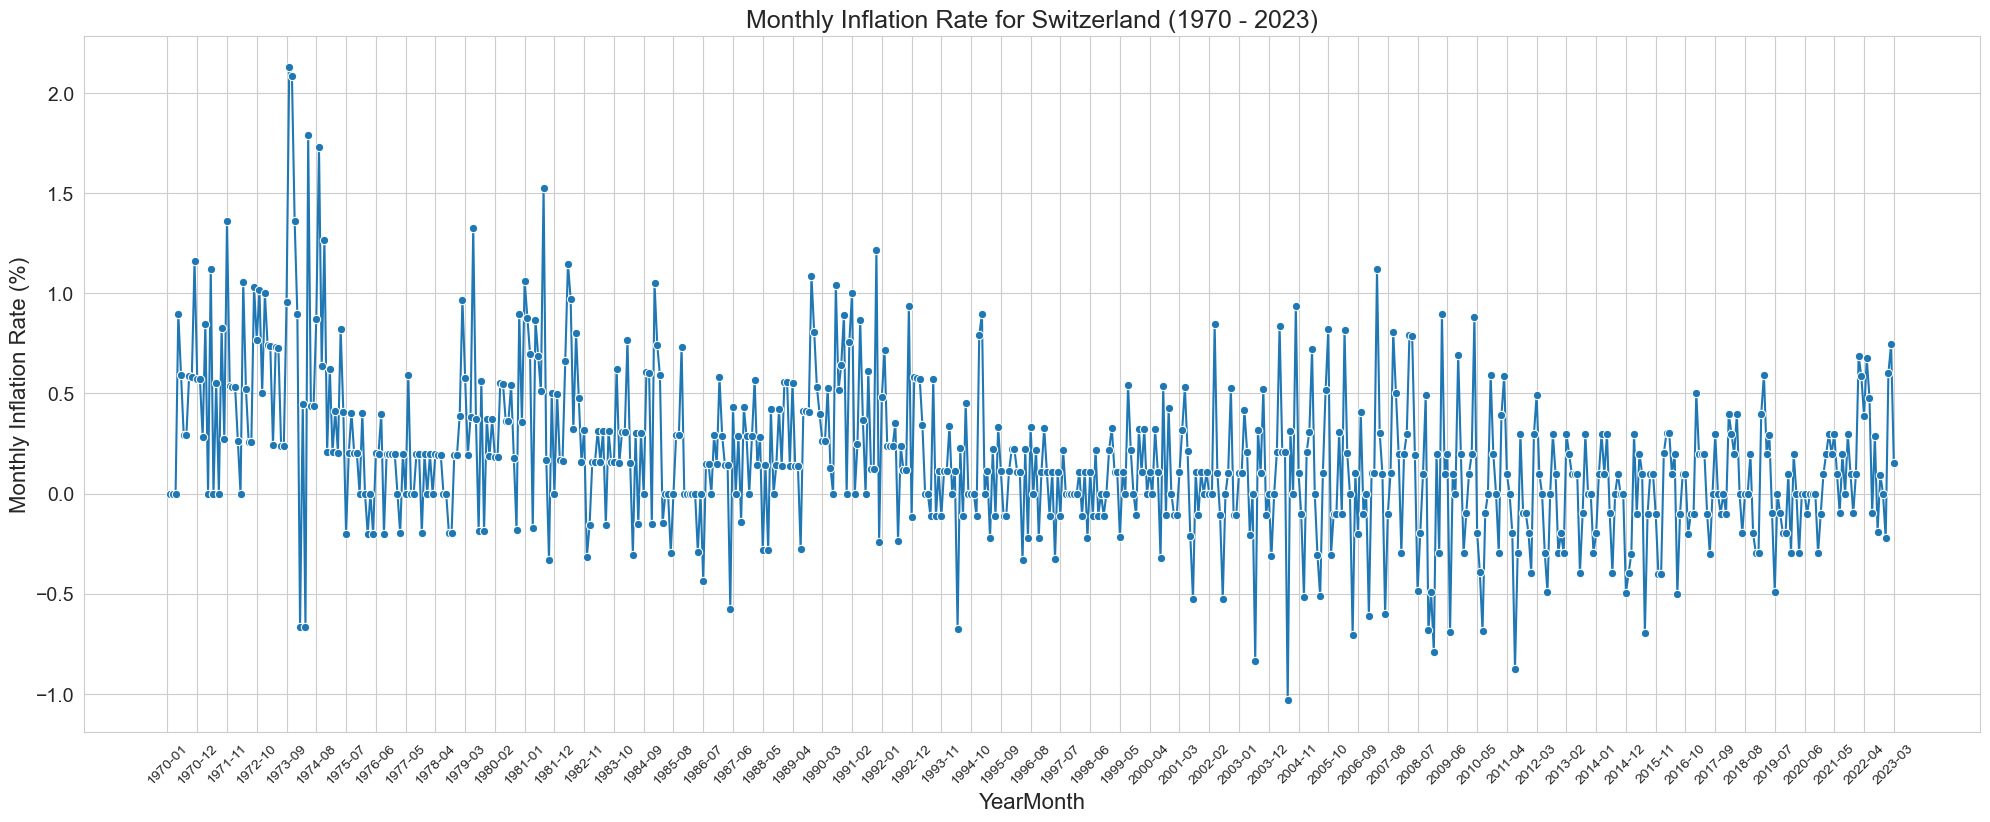

In [152]:

Switzerland_sample['YearMonth'] = Switzerland_sample['YearMonth'].astype(str)
selected_years = Switzerland_sample['YearMonth'].unique()[::11]

plt.figure(figsize=(20, 8))
sns.lineplot(data=Switzerland_sample, x='YearMonth', y='Monthly Inflation Rate', marker='o')
plt.title('Monthly Inflation Rate for Switzerland (1970 - 2023)', fontsize=18)

plt.ylabel('Monthly Inflation Rate (%)', fontsize=16) 
plt.yticks(fontsize=14)   

plt.xlabel('YearMonth', fontsize=16) 

plt.xticks(selected_years)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


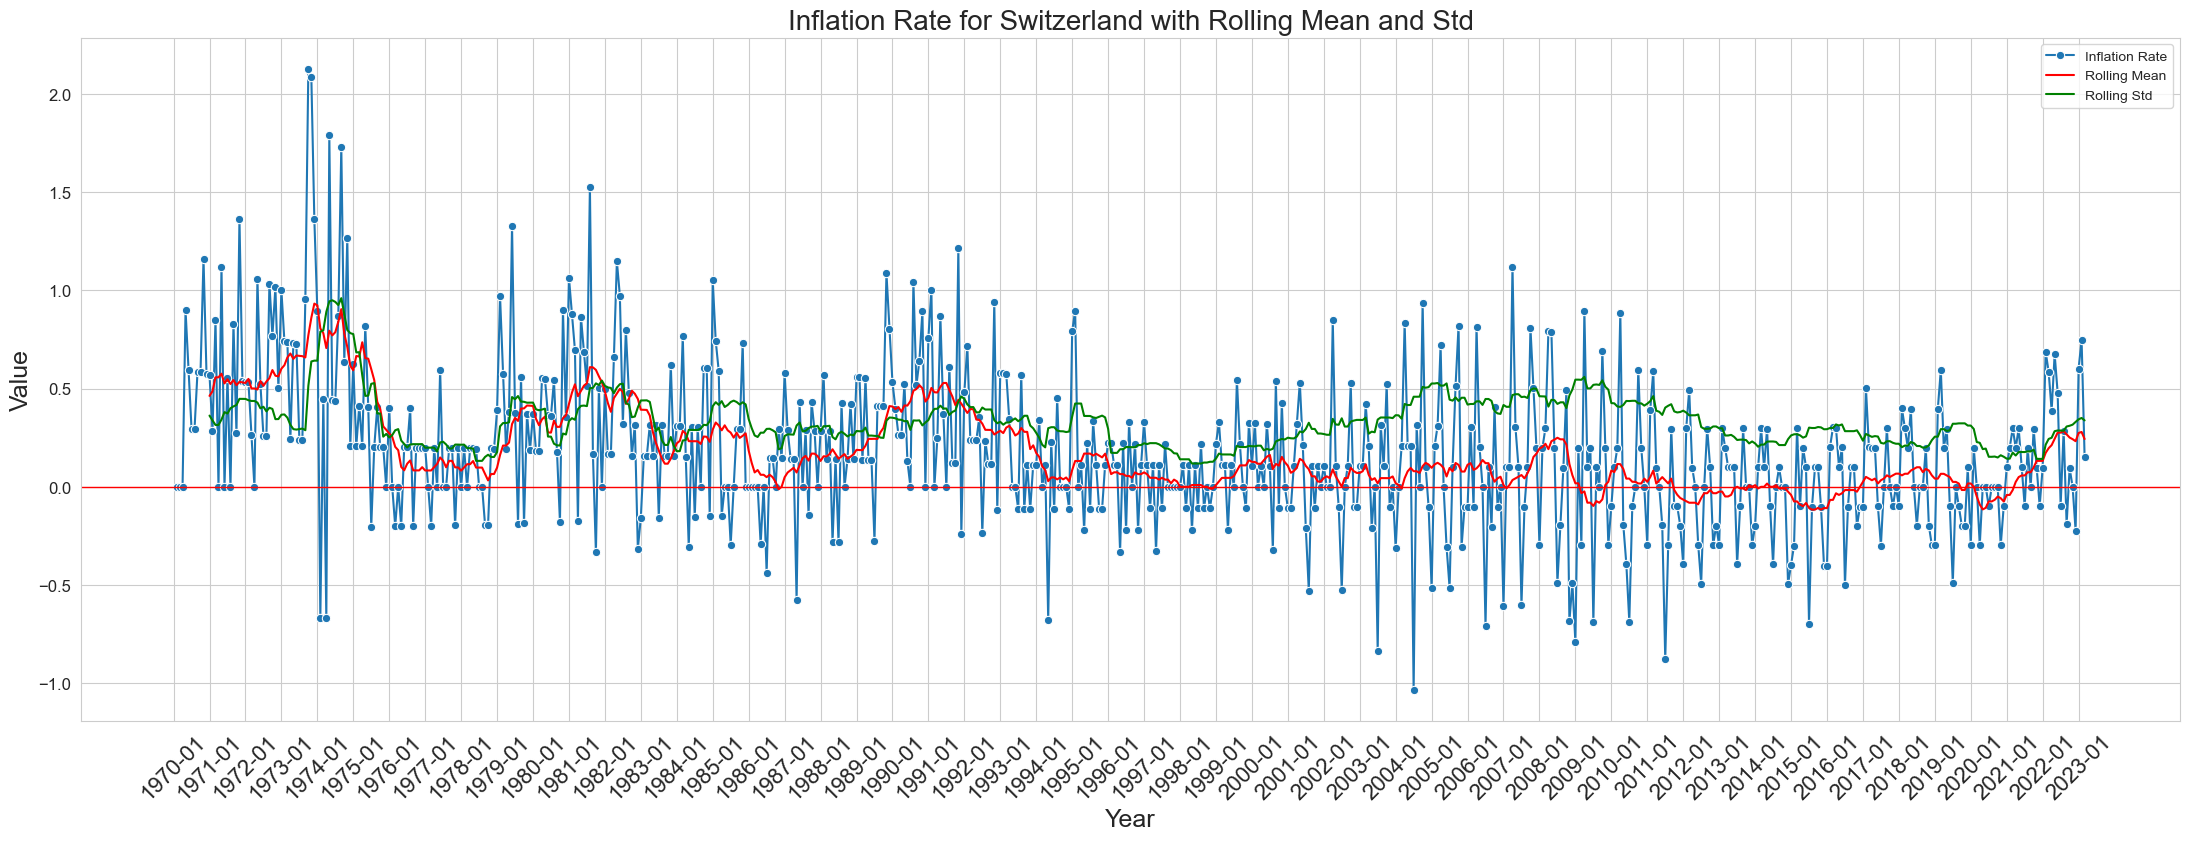

In [153]:

Switzerland_sample['YearMonth'] = Switzerland_sample['YearMonth'].astype(str)
selected_years = Switzerland_sample['YearMonth'].unique()[::12]

rolling_mean = Switzerland_sample['Monthly Inflation Rate'].rolling(window=12).mean()
rolling_std = Switzerland_sample['Monthly Inflation Rate'].rolling(window=12).std()

plt.figure(figsize=(22, 8))

sns.lineplot(data=Switzerland_sample, x='YearMonth', y='Monthly Inflation Rate', marker='o', label='Inflation Rate')
sns.lineplot(data=Switzerland_sample, x='YearMonth', y=rolling_mean, color='r', label='Rolling Mean')
sns.lineplot(data=Switzerland_sample, x='YearMonth', y=rolling_std, color='g', label='Rolling Std')

plt.title('Inflation Rate for Switzerland with Rolling Mean and Std', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.xticks(selected_years, fontsize=16)
plt.yticks(fontsize=12)
plt.grid(True)

plt.axhline(0, color='red', linewidth=1)
plt.tight_layout()
plt.xticks(rotation=45) 
plt.legend() 
plt.show()


In [154]:

yearly_inflation = get_yearly_inflation_from_monthly(Switzerland_sample)
yearly_inflation.dropna(inplace=True)


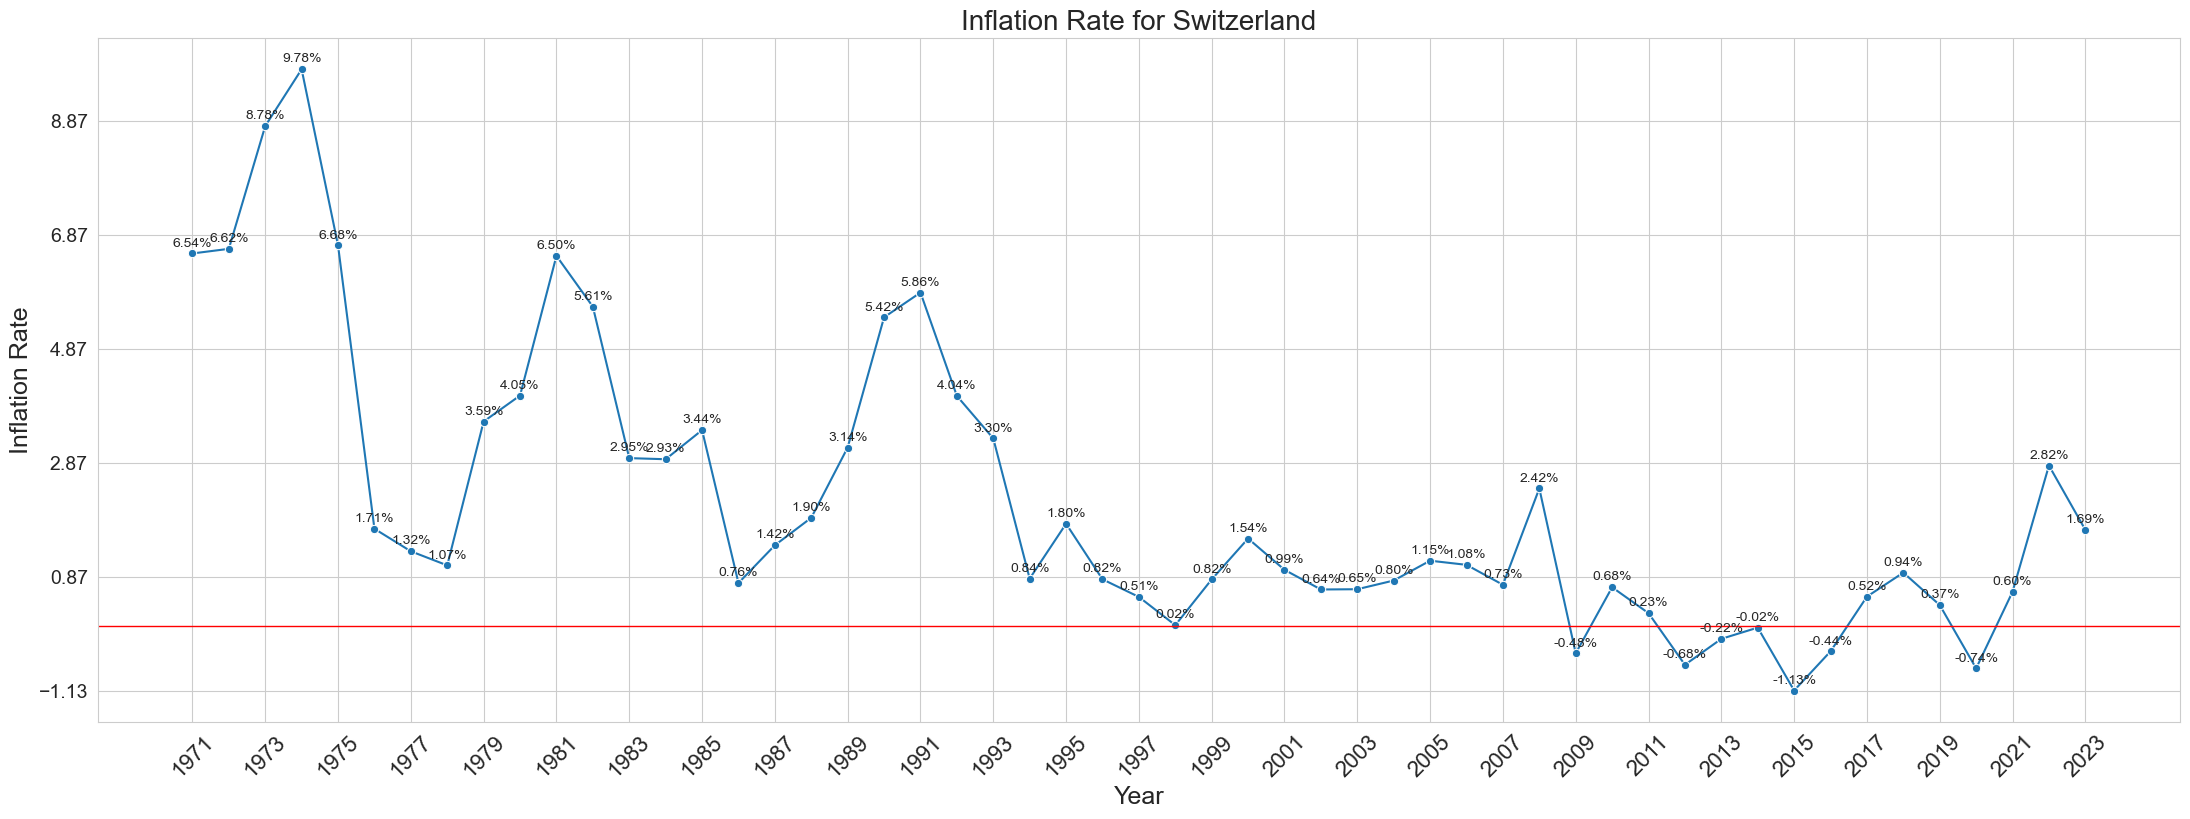

In [155]:

yearly_inflation['Year'] = yearly_inflation['Year'].astype(str)
selected_years = yearly_inflation['Year'].unique()[::2]

plt.figure(figsize=(22, 8))
sns.lineplot(data=yearly_inflation, x='Year', y='Yearly Inflation Rate (Avg)', marker='o')
plt.title('Inflation Rate for Switzerland', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Inflation Rate', fontsize=18)
plt.xticks(selected_years, fontsize=16) 
plt.yticks(fontsize=16)

plt.yticks(np.arange(min(yearly_inflation['Yearly Inflation Rate (Avg)']), max(yearly_inflation['Yearly Inflation Rate (Avg)'])+1, 2), fontsize=14)
plt.grid(True)

for idx, row in yearly_inflation.iterrows():
    plt.annotate(f"{row['Yearly Inflation Rate (Avg)']:.2f}%",
                 (row['Year'], row['Yearly Inflation Rate (Avg)']),
                 textcoords="offset points", xytext=(0,5), ha='center',
                 fontsize=10)

plt.axhline(0, color='red',
            linewidth=1)
plt.tight_layout()
plt.xticks(rotation=45)  
plt.show()


### Observations:
- No clear trend or seasonality is shown from Switzerland's yearly inflation rates.
- Inflation rates go below zero from 2007 to 2015 with an evidence spike or upward trend from 2019 to 2021.
- Overall, the series exhibits stability for each 5 years.

## Statistical Analysis:

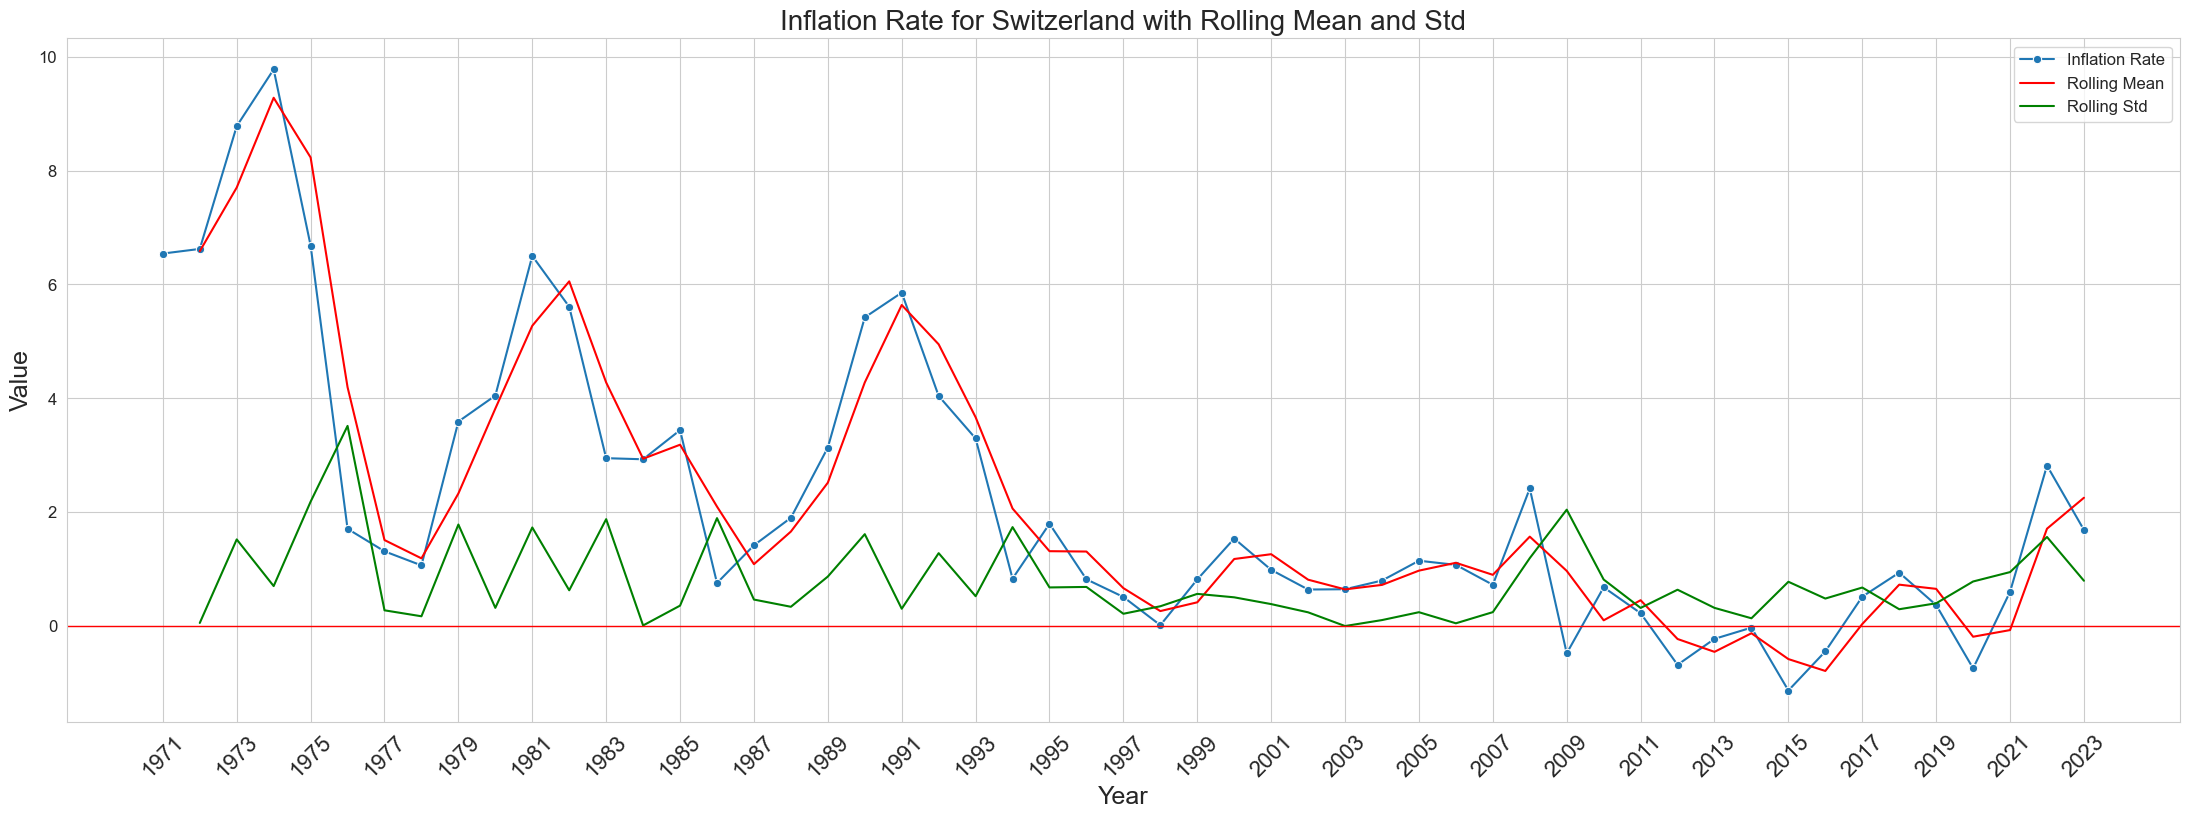

In [156]:

yearly_inflation['Year'] = yearly_inflation['Year'].astype(str)
selected_years = yearly_inflation['Year'].unique()[::2]

rolling_mean = yearly_inflation['Yearly Inflation Rate (Avg)'].rolling(window=2).mean()
rolling_std = yearly_inflation['Yearly Inflation Rate (Avg)'].rolling(window=2).std()

plt.figure(figsize=(22, 8))

sns.lineplot(data=yearly_inflation, x='Year', y='Yearly Inflation Rate (Avg)', marker='o', label='Inflation Rate')
sns.lineplot(data=yearly_inflation, x='Year', y=rolling_mean, color='r', label='Rolling Mean')
sns.lineplot(data=yearly_inflation, x='Year', y=rolling_std, color='g', label='Rolling Std')

plt.title('Inflation Rate for Switzerland with Rolling Mean and Std', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Value', fontsize=18)
plt.xticks(selected_years, fontsize=16)
plt.yticks(fontsize=12)
plt.grid(True)

plt.axhline(0, color='red', linewidth=1)

plt.tight_layout()
plt.xticks(rotation=45) 
plt.legend(fontsize='large')  
plt.show()


### Observations: 
- The moving average of 12 months fits the series well over the years.
- Moving std is unable to capture the sudden upward and downward trend between in the series.

In [157]:

Switzerland_sample.dropna(inplace=True)


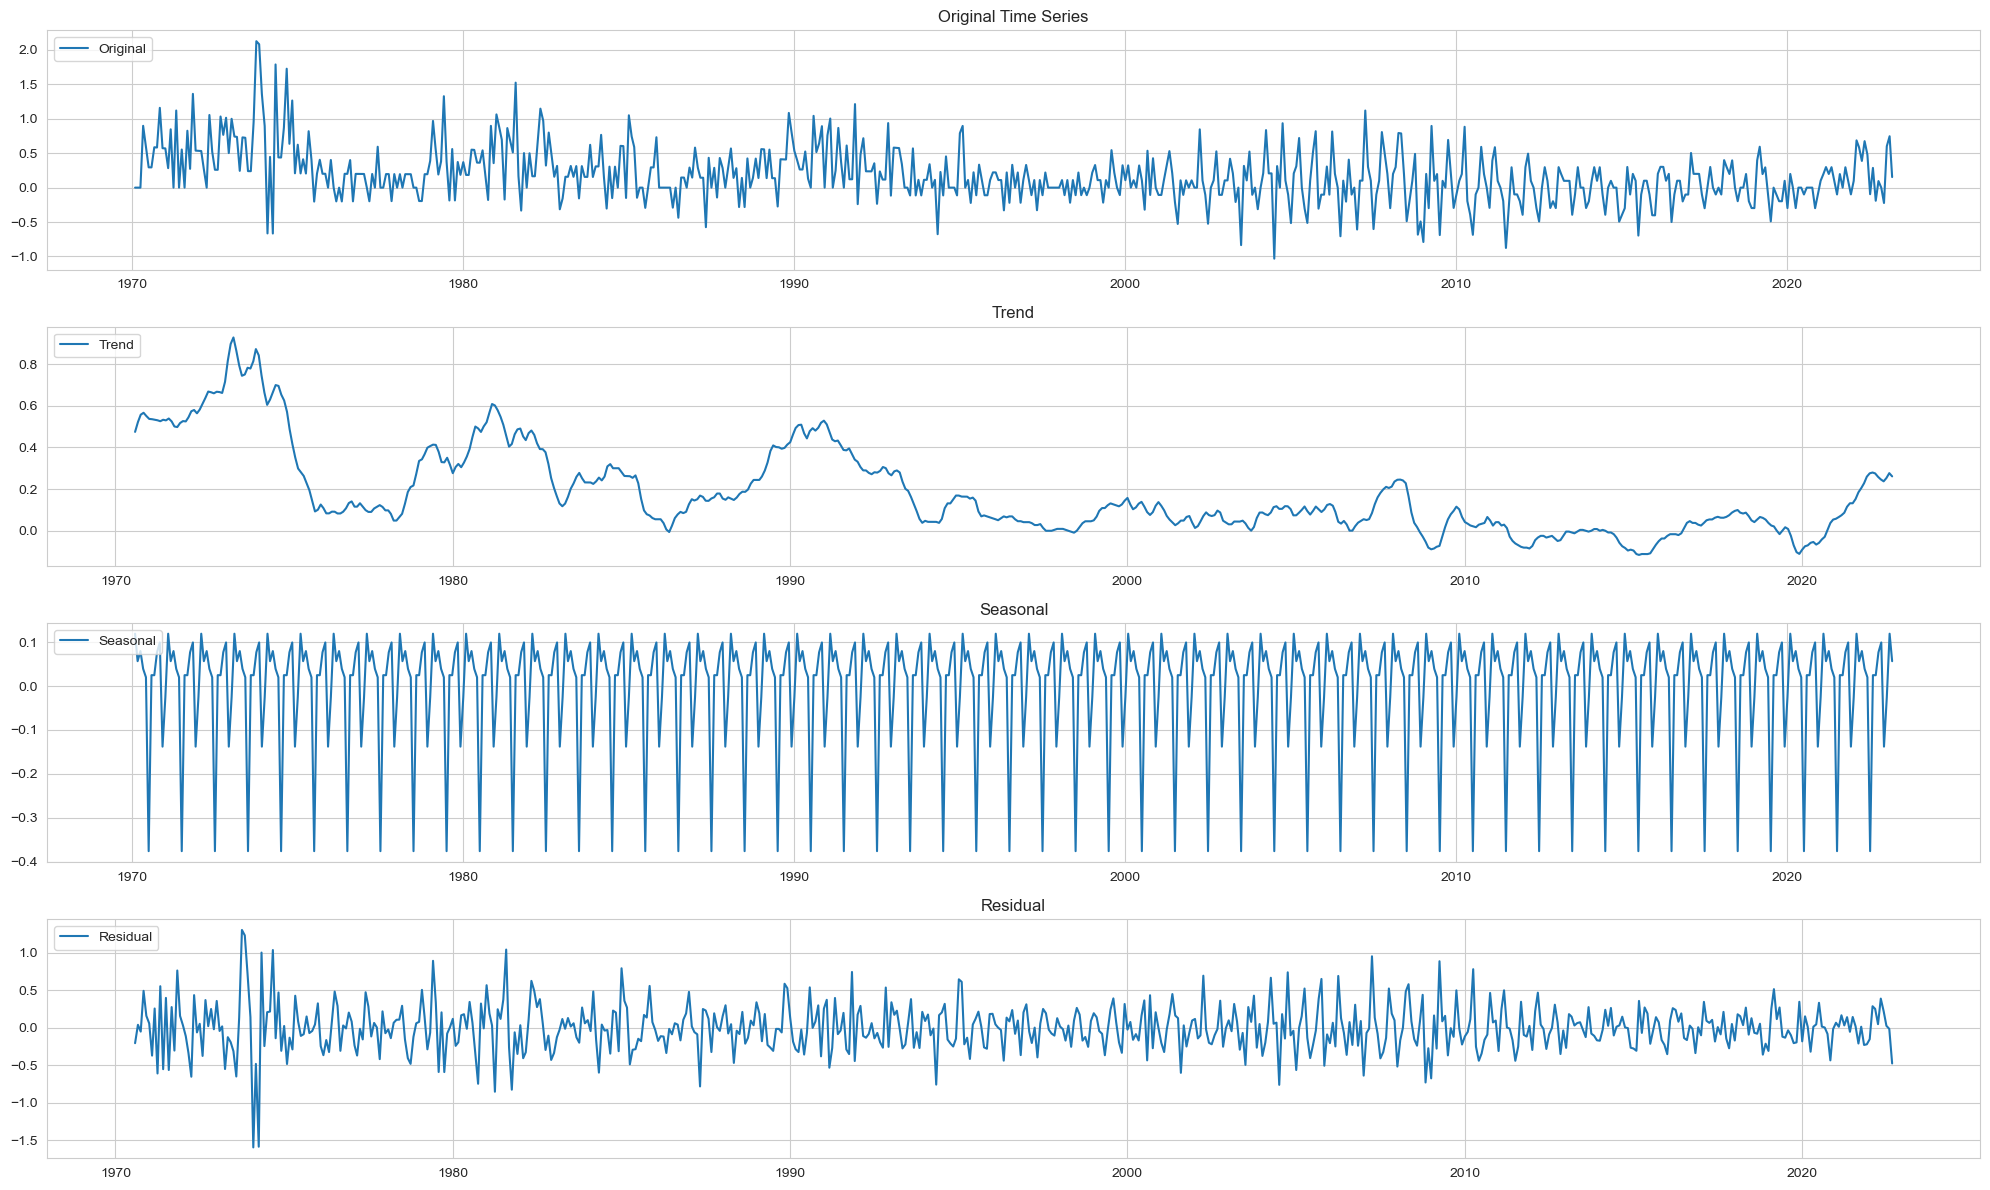

In [158]:

Switzerland_sample['Date'] = pd.to_datetime(Switzerland_sample['YearMonth'])
Switzerland_sample.set_index('Date', inplace=True)

decomposition = seasonal_decompose(Switzerland_sample['Monthly Inflation Rate'], model='additive')

plt.figure(figsize=(20, 12))

# Original
plt.subplot(4, 1, 1)
plt.plot(Switzerland_sample['Monthly Inflation Rate'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Time Series')

# Trend
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend')

# Seasonal
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal')

# Residual
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual')

plt.tight_layout()
plt.show()


### Observations:
- We can see no clear observation of trends in the series from 1970 till 1990. 
- Slight downward trend from 1990 to 2000.
- A seasonable trend is clearly observable from the above graph.
- Residual show a very stable series with constant mean across the years.

In [159]:

adf_test(Switzerland_sample["Monthly Inflation Rate"])


======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: -2.759119
2. P-value: 0.064355
3. Used Lags: 12
4. Used Observations: 625
5. Critical Values:
	1%: -3.440856
	5%: -2.866175
	10%: -2.569239

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


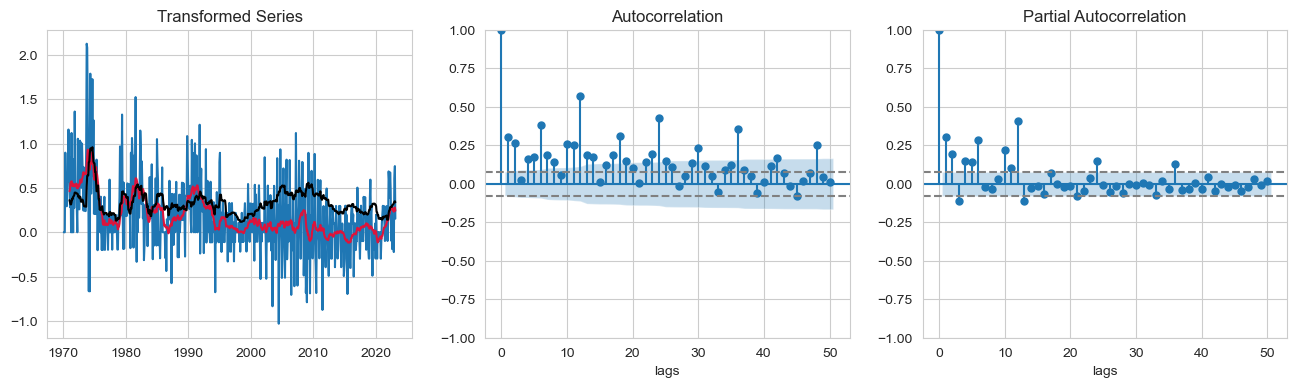

P-value = 0.064355, the series is likely non-stationary.


In [160]:

series_transformation(Switzerland_sample["Monthly Inflation Rate"])


In [161]:

Switzerland_sample['Differenced'] = Switzerland_sample['Monthly Inflation Rate'].diff()
Switzerland_sample.dropna(inplace=True)
Switzerland_sample.head(20)


,YearMonth,HCPI,Monthly Inflation Rate,Differenced
Date,,,,
1970-03-01,1970-03,33.4,0.0,0.0
1970-04-01,1970-04,33.4,0.0,0.0
1970-05-01,1970-05,33.7,0.898204,0.898204
1970-06-01,1970-06,33.9,0.593472,-0.304732
1970-07-01,1970-07,34.0,0.294985,-0.298487
1970-08-01,1970-08,34.1,0.294118,-0.000868
1970-09-01,1970-09,34.3,0.58651,0.292393
1970-10-01,1970-10,34.5,0.58309,-0.00342
1970-11-01,1970-11,34.9,1.15942,0.57633


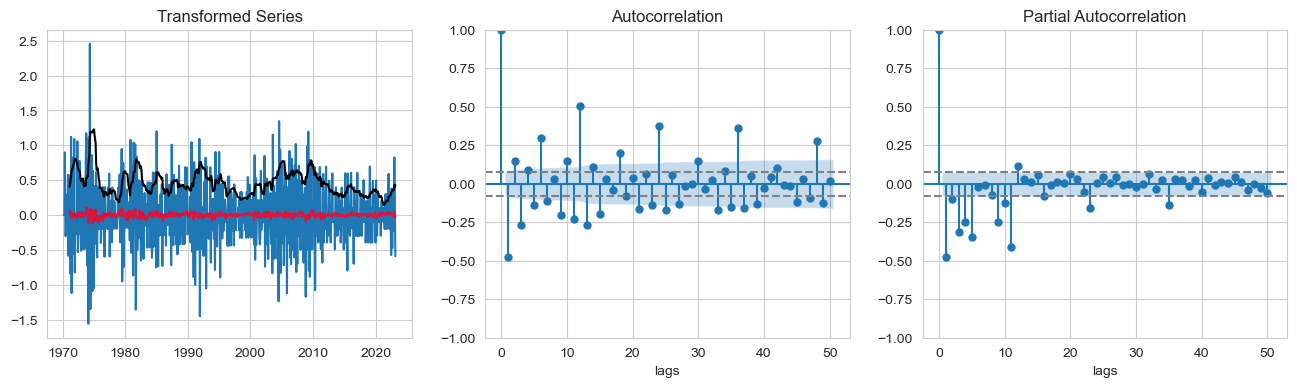

P-value = 0.000000, the series is likely stationary.


In [162]:

series_transformation(Switzerland_sample["Differenced"])


### Observations:
- P-value: 0.064355 of ADF test shows slight non-stationary properties in the series.
- Taking first order differencing results in P-value of 0.00000, makes the series stationary.
- In auto-correlation plot, spikes at 0, 1,3,6,9,10,11, given the length of the time series we won't consider all lags.
- In the partial autocorrection plot, we see significant spikes at 0,1,3,4,5,9 and 11, terms for moving average component of the time series, but we won't consider all terms to avoid the risk of over-fitting.
- we can see how first order differencing changed the lags of autocorrection plot significantly and infunce the significant spikes in lags.

In [163]:

Switzerland_sample["Monthly Inflation Rate"] = Switzerland_sample["Monthly Inflation Rate"].astype(float)
Switzerland_sample.head(20)


,YearMonth,HCPI,Monthly Inflation Rate,Differenced
Date,,,,
1970-03-01,1970-03,33.4,0.000000,0.0
1970-04-01,1970-04,33.4,0.000000,0.0
1970-05-01,1970-05,33.7,0.898204,0.898204
1970-06-01,1970-06,33.9,0.593472,-0.304732
1970-07-01,1970-07,34.0,0.294985,-0.298487
1970-08-01,1970-08,34.1,0.294118,-0.000868
1970-09-01,1970-09,34.3,0.586510,0.292393
1970-10-01,1970-10,34.5,0.583090,-0.00342
1970-11-01,1970-11,34.9,1.159420,0.57633


## ARIMA Model:
#### Search ARIMA parameters:

In [164]:

series = Switzerland_sample["Monthly Inflation Rate"]


### Full Data Parm Search:

In [ ]:

train_size = int(len(series) * 0.9)
train, test = series[0:train_size], series[train_size:]
best_order = find_best_arima_params(train)
best_order


In [ ]:
best_order_metric = find_best_arima_params_metric(train)
best_order_metric


#### Train and predict using ARIMA model with the best ARIMA order extracted:

In [ ]:

series = Switzerland_sample["Monthly Inflation Rate"]

train_size = int(len(series) * 0.8)
train, test = series[0:train_size], series[train_size:]
train = train[-100:]

best_order = (4, 1, 4)


model = ARIMA(train, order=best_order)
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

rmspe = np.sqrt(mean_squared_error(test, forecast))

test_length = len(test)

plt.figure(figsize=(25, 10))
plt.plot(train, label='Training Data')
plt.plot(test.index, forecast, color='red', label='Predicted')
plt.plot(test.index, test, color='green', linestyle='dashed', label='Actual')

plt.title("ARIMA"+str(best_order)+" Forecast vs Actuals", fontsize=20)
plt.legend(loc='best', prop={'size': 16})

plt.grid(True)
plt.annotate(f'RMSPE: {rmspe:.3f}', xy=(0.75, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

plt.annotate(f'Test Length: {test_length} months', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=14, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

years = pd.date_range(start=train.index.min(), end=test.index.max(), freq='2Y')
plt.xticks(years, years.strftime('%Y'), fontsize=14)
plt.yticks(fontsize=14)
plt.show()


In [ ]:

results_df = pd.DataFrame({
    'Actual': test,
    'Predicted': forecast
})
results_df


### SARIMAX Model:
#### Search SARIMAX Parameters Space:

In [ ]:

model =auto_arima(train, 
                  start_p=1, 
                  start_q=1,
                  max_p=8, 
                  max_q=8,
                  start_P=0,
                  start_Q=0,
                  max_P=8,
                  max_Q=8,
                  m=12,
                  seasonal=True, 
                  trace=True,
                  d=1,
                  D=1,
                  error_action='warn', 
                  suppress_warnings=True, 
                  random_state = 20,
                  n_fits=100)

print(model.summary())


In [ ]:

series = Switzerland_sample["Monthly Inflation Rate"]

train_size = int(len(series) * 0.8)
train, test = series[0:train_size], series[train_size:]

model = SARIMAX(train,
                order=(3, 1, 0),
                seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False,
                )

model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps=len(test))
rmspe = np.sqrt(mean_squared_error(test, forecast))

plt.figure(figsize=(25, 10))
plt.plot(train, label='Training Data')
plt.plot(test.index, forecast, color='red', label='Predicted')
plt.plot(test.index, test, color='green', linestyle='dashed', label='Actual')
plt.title('SARIMA Model Forecast vs Actuals', fontsize=20)
plt.legend(loc='best', prop={'size': 14})
plt.grid(True)

plt.annotate(f'RMSPE: {rmspe:.3f}', xy=(0.75, 0.95), xycoords='axes fraction',
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))
plt.yticks(fontsize=14)
plt.show()


In [ ]:

results_df = pd.DataFrame({
    'Actual': test,
    'Predicted': forecast
})
results_df


### Further analysis of models:
#### Forecasting ARIMA:

In [ ]:

def forecast_arima(series, order=(0, 0, 0)):    
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    yhat = model_fit.predict(start=0, end=len(series)-1, typ='levels').rename('Predict')

    plt.figure(figsize=(24, 10))
    series.plot(legend=True, label='Actual', color='gray')
    yhat.plot(legend=True, label='Predicted', color='yellow')
    plt.title('Predict vs Actual Rates')
    plt.legend()
    plt.show()

forecast_arima(Switzerland_sample["Monthly Inflation Rate"], order=(4, 1, 4))


#### Forecasting with SARIMA:

In [ ]:

def forecast_sarimax(series, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0)):
    sarimax_model = SARIMAX(series, order=order, seasonal_order=seasonal_order)
    model_fitted = sarimax_model.fit(disp=False)

    yhat = model_fitted.predict(start=0, end=len(series) - 1, typ='levels').rename('Predict')

    plt.figure(figsize=(24, 10))
    series.plot(legend=True, label='Actual', color='gray')
    yhat.plot(legend=True, label='Predicted', color='green')
    plt.title('Predict vs Actual Rates')
    plt.legend()
    plt.show()

forecast_sarimax(Switzerland_sample["Monthly Inflation Rate"], 
                 order=(1,1,3),
                 seasonal_order=(1, 1, 1, 6))



### Generate Forecasting for the next 5 Years:

In [ ]:

data = pd.read_csv("Monthly Inflation Rate")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


model =auto_arima(data["Monthly Inflation Rate"],
                  start_p=1,
                  start_q=1,
                  max_p=8,
                  max_q=8,
                  start_P=0,
                  start_Q=0,
                  max_P=8,
                  max_Q=8,
                  m=12,
                  seasonal=True,
                  trace=True,
                  d=1,
                  D=1,
                  error_action='warn',
                  suppress_warnings=True,
                  random_state = 222,
                  n_fits=200)

print(model.summary())



In [ ]:

model = sm.tsa.statespace.SARIMAX(data["Monthly Inflation Rate"],
                                  order=(1,1,3),
                                  seasonal_order=(1, 1, 1, 12),
                                  enforce_stationarity=True,
                                  enforce_invertibility=True)


fit_model = model.fit(disp=False)

forecast = fit_model.get_forecast(steps=60)

predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

predicted_mean, conf_int.head()

forecast_index = pd.date_range(data.index[-1], periods=60, freq='MS')


In [ ]:

yearly_predicted_mean = predicted_mean.resample('Y').sum()
yearly_predicted_mean.index = yearly_predicted_mean.index.year
yearly_predicted_mean.index = pd.to_datetime(yearly_predicted_mean.index, format='%Y')

yearly_conf_int_lower = conf_int['lower Monthly Inflation Rate'].resample('Y').sum()
yearly_conf_int_upper = conf_int['upper Monthly Inflation Rate'].resample('Y').sum()

yearly_data = data.resample('Y').sum()
yearly_data.index = yearly_data.index.year
yearly_data.index = pd.to_datetime(yearly_data.index, format='%Y')

plt.figure(figsize=(20, 7))
plt.plot(yearly_data.index, yearly_data['Monthly Inflation Rate'], label='Historical Data', color='blue')

plt.plot(yearly_predicted_mean.index, yearly_predicted_mean, label='Yearly Forecast', color='red', linestyle='--')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ymin, ymax = plt.ylim()
plt.yticks(np.arange(ymin, ymax, (ymax-ymin)/20))  

ax.tick_params(axis='x', labelsize=12)  
ax.tick_params(axis='y', labelsize=12)  

for date, value in zip(yearly_data.index, yearly_data['Monthly Inflation Rate']):
    ax.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10)

for date, value in zip(yearly_predicted_mean.index, yearly_predicted_mean):
    ax.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='red')

plt.title('Yearly Inflation Rate and Forecast for Switzerland (2024-2028) - SARIMAX Model', fontsize=18)
plt.xlabel('Date', fontsize=16)  
plt.ylabel('Yearly Inflation Rate (%)', fontsize=16)  
plt.legend(fontsize='x-large') 
plt.grid(True)
plt.tight_layout()
plt.show()



### How far such model can predict inflation rate accurately? 

Given the limitation of the uni-variate data we have previously used in forecasting inflation and experimenting with different models, one question came to mind is how far we can forecast inflation from a previous pattern of the data.
Given the monetary series stochastic nature and the many random factors that influences the change in inflation over the years, it is always better to state with humility the limitation of the data the model.

In [ ]:

data = pd.read_csv("Monthly Inflation Rate")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)


#### Split and prepare data:

In [ ]:

series = data["Monthly Inflation Rate"]

train_end_index = int(0.8 * len(series))
train_data = series.iloc[:train_end_index]


start_test = train_end_index

test_data = []
test_labels = []

for i in range(1, 11):  # Using 1 to 10 for easier multiplication
    end_test = start_test + 6 * i  # i * 6 months for accumulation
    test_split = series.iloc[train_end_index:end_test]  # Always start from train_end_index
    test_data.append(test_split)
    test_labels.append(f"{i * 6} months")

# Adjust the test_data and test_labels lists to match the desired splits
test_data = test_data[:5] + [test_data[-3], test_data[-2], test_data[-1]]
test_labels = test_labels[:5] + [test_labels[-3], test_labels[-2], test_labels[-1]]



In [ ]:

predictions = []
rmses = []
results = []

for i, test in enumerate(test_data):

    model_ = ARIMA(train_data,
                   order=(4, 1, 4),
                   )
    fit_model = model_.fit()
    forecast = fit_model.forecast(steps=len(test))
    predictions.append(forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmses.append(rmse)
    print(f'RMSE for {test_labels[i]} test set: {rmse:.2f}')

    fig, ax = plt.subplots(1, 2, figsize=(20,7))

    font_size_axis = 14
    ax[0].tick_params(axis='both', labelsize=font_size_axis)
    ax[1].tick_params(axis='both', labelsize=font_size_axis)

    ax[0].plot(series.index[:train_end_index + len(forecast)], series.values[:train_end_index + len(forecast)], label='Original Series', color='blue')
    fitted_indices = series.index[train_end_index - len(fit_model.fittedvalues):train_end_index]
    ax[0].plot(fitted_indices, fit_model.fittedvalues, color='red', label='Fitted Values')
    forecast_index = range(train_end_index, train_end_index + len(forecast))
    ax[0].plot(series.index[forecast_index], forecast, label=f'Forecast {test_labels[i]}', color='green')

    font_size_legend = 12
    font_size_title = 16

    ax[0].legend(fontsize=font_size_legend)
    ax[0].set_title(f'SARIMA Model Forecast for {test_labels[i]} Test Set - RMSE: {rmse:.2f}', fontsize=font_size_title)

    # Plot for true vs predicted values
    ax[1].plot(series.index[forecast_index], test, label='True Values', color='blue')
    ax[1].plot(series.index[forecast_index], forecast, label='Predicted Values', color='green')
    test_length_years = format_year(len(test) / 12.0)
    ax[1].set_title(f'True vs Predicted Values for {test_labels[i]} Test Set ({test_length_years} years)', fontsize=font_size_title)
    ax[1].legend(fontsize=font_size_legend)

    plt.tight_layout()
    plt.show()

    df = pd.DataFrame({
        'Date': series.index[forecast_index],
        'True Values': test.values,
        'Predicted Values': forecast,
        'Forecasting in Months':test_labels[i],
        'Test Set Label':i,
        'Years': test_length_years
    })
    results.append(df)


In [ ]:

predictions = []
rmses = []
results = []

for i, test in enumerate(test_data):

    model_ = sm.tsa.statespace.SARIMAX(train_data,
                                       order=(1,1,3),
                                       seasonal_order=(2, 0, 1, 12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)



    fit_model = model_.fit(optimized=True, use_brute=True,disp=False)
    forecast = fit_model.forecast(steps=len(test))
    predictions.append(forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    rmses.append(rmse)
    print(f'RMSE for {test_labels[i]} test set: {rmse:.2f}')

    fig, ax = plt.subplots(1, 2, figsize=(20,7))

    font_size_axis = 14
    ax[0].tick_params(axis='both', labelsize=font_size_axis)
    ax[1].tick_params(axis='both', labelsize=font_size_axis)

    ax[0].plot(series.index[:train_end_index + len(forecast)], series.values[:train_end_index + len(forecast)], label='Original Series', color='blue')
    fitted_indices = series.index[train_end_index - len(fit_model.fittedvalues):train_end_index]
    ax[0].plot(fitted_indices, fit_model.fittedvalues, color='red', label='Fitted Values')
    forecast_index = range(train_end_index, train_end_index + len(forecast))
    ax[0].plot(series.index[forecast_index], forecast, label=f'Forecast {test_labels[i]}', color='yellow')

    font_size_legend = 12
    font_size_title = 16

    ax[0].legend(fontsize=font_size_legend)
    ax[0].set_title(f'SARIMA Model Forecast for {test_labels[i]} Test Set - RMSE: {rmse:.2f}', fontsize=font_size_title)

    ax[1].plot(series.index[forecast_index], test, label='True Values', color='blue')
    ax[1].plot(series.index[forecast_index], forecast, label='Predicted Values', color='yellow')
    test_length_years = format_year(len(test) / 12.0)
    ax[1].set_title(f'True vs Predicted Values for {test_labels[i]} Test Set ({test_length_years} years)', fontsize=font_size_title)
    ax[1].legend(fontsize=font_size_legend)

    plt.tight_layout()
    plt.show()


    df = pd.DataFrame({
        'Date': series.index[forecast_index],
        'True Values': test.values,
        'Predicted Values': forecast,
        'Forecasting in Months':test_labels[i],
        'Test Set Label':i,
        'Years': test_length_years
    })
    results.append(df)


In [ ]:

final_results = pd.concat(results, axis=0)
final_results.reset_index(drop=True, inplace=True)
final_results.set_index("Date",inplace=True)


unique_labels = final_results['Years'].unique()
n_labels = len(unique_labels)

n_rows = int(np.ceil(n_labels / 3))

fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
fig.suptitle('True vs Predicted Values for Each Test Set Label', y=1.05)

if n_rows == 1:
    axes = np.reshape(axes, (1, -1))

for i, label in enumerate(unique_labels):
    row, col = divmod(i, 3)
    ax = axes[row, col]
    subset = final_results[final_results['Years'] == label]
    
    mse = mean_squared_error(subset['True Values'], subset['Predicted Values'])
    rmse = np.sqrt(mse)

    label_text = f'MSE = {mse:.2f}, RMSE = {rmse:.2f}'
    ax.scatter(subset['True Values'], subset['Predicted Values'], color='green', alpha=0.6, label=label_text, marker='s')

    ax.plot([-1, 1], [-1, 1], color='red', linestyle='--')
    ax.legend(loc='upper left', fontsize=12)
    ax.set_title(f"Years: {label}", fontsize=14)
    ax.set_xlabel('True Values', fontsize=13)
    ax.set_ylabel('Predicted Values', fontsize=13)
    ax.grid(True)

for j in range(i+1, 3 * n_rows):
    row, col = divmod(j, 3)
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

